> This file is an example of how to solve an optimisation problem in Dask. The particle swarm optimiser algorithm has been implemented in this file and is meant to serve as an example of running a compute intensive task using Dask. In this particular case, we split the search space into a grid and the PSO algorithm finds a minima for each cell of the grid. Once the minima of all the cells in the grid have been computed, the lowest of these minima is reported as the global minima of the optimisaton

In [1]:
# Import the required libraries

import dask
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import os
import random


from dask.distributed import Client

In [2]:
# Connect to the cluster and create a client to interact with the cluster
service_host = os.environ["DASK_SCHEDULER_SERVICE_HOST"]
print(service_host)

service_port = os.environ["DASK_SCHEDULER_SERVICE_PORT"]
client = Client(f"{service_host}:{service_port}")

dask-65cfbc54f4737958db87e57f-dask-scheduler.domino-compute.svc.cluster.local


In [3]:
# Define the objective function to optimise
def f(x, y):
    # Objective function
    return (x - 3.14) ** 2 + (y - 2.72) ** 2 + np.sin(3 * x + 1.41) + np.sin(4 * y - 1.73)

In [4]:
# Plot the objective function and the minima along with the parameters that correspond to the minima
plot_l_bound = 0
plot_r_bound = 10
x, y = np.array(np.meshgrid(np.linspace(plot_l_bound, plot_r_bound, plot_r_bound**2), np.linspace(plot_l_bound, plot_r_bound, 100)))
z = f(x, y)
    
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]
f_min = f(x_min,y_min)

Global optimal at f(3.2323,3.1313) = -1.7961


(0.0, 10.0)

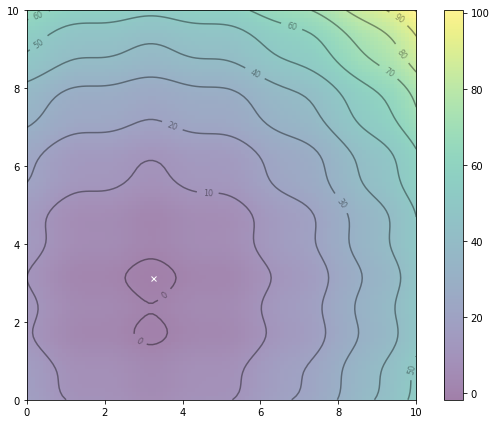

In [5]:
print(f"Global optimal at f({x_min:.4f},{y_min:.4f}) = {f(x_min, y_min):.4f}")
# Set up base figure: The contour map
fig, ax = plt.subplots(figsize=(8, 6))
fig.set_tight_layout(True)
img = ax.imshow(z, extent=[0, plot_r_bound, plot_l_bound, plot_r_bound], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
ax.set_xlim([plot_l_bound, plot_r_bound])
ax.set_ylim([plot_l_bound, plot_r_bound])

In [6]:
# Define the particle swarm optimizer as a Dask function, all thats is needed is a decorator
@dask.delayed
def pso(bounds:tuple=(0,10,0,10)):
    
    n_iter = 25
    x_l_bound = bounds[0]
    x_r_bound = bounds[1]
    
    y_l_bound = bounds[2]
    y_r_bound = bounds[3]
    
    # Create particles
    n_particles = 50
    np.random.seed(100)
    x = x_l_bound + (np.random.rand(n_particles) * (x_r_bound - x_l_bound))
    y = y_l_bound + (np.random.rand(n_particles) * (y_r_bound - y_l_bound))
    X = np.vstack((x,y))
    # X = l_bound + (np.random.rand(2, n_particles) * (r_bound -l_bound))
    V = np.random.randn(2, n_particles) * 0.1
 
    # Initialize data
    pbest = X
    pbest_obj = f(X[0], X[1])
    gbest = pbest[:, pbest_obj.argmin()]
    gbest_obj = pbest_obj.min()
    
    # Hyper-parameter of the algorithm
    c1 = c2 = 0.1
    w = 0.8
    
    for i in range(n_iter):
        # Update params
        r1, r2 = np.random.rand(2)
        V = w * V + c1 * r1 * (pbest - X) + c2 * r2 * (gbest.reshape(-1, 1) - X)
        X = X + V
        obj = f(X[0], X[1])
        pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
        pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
        gbest = pbest[:, pbest_obj.argmin()]
        gbest_obj = pbest_obj.min()

    return gbest,gbest_obj 
    
    

In [7]:
# Split the search space into a 2*2 grid of subspaces
# Apply the PSO to each subspace and get a local minima
# Take the minimum value of the local minima that is returned from the subspaces and use that as the global minima

# Break the search space into an M*N grid
M = 2
N = 2

min_x = plot_l_bound
max_x = plot_r_bound

min_y = plot_l_bound
max_y = plot_r_bound

x = np.linspace(min_x, max_x, M + 1)
y = np.linspace(min_y, max_y, N + 1)

# Get the range for each of the subspaces in the M*N grid
pso_ranges = []
for i in range(M):
    for j in range(N):
        pso_ranges.append((x[i], x[i + 1], y[j], y[j+1]))

In [8]:
# Store the local minima in this list
pso_results = []
for pso_range in pso_ranges:
    # Create delayed Dask objects where each object corresponds to a call to the PSO for a subspace
    pso_result = dask.delayed(pso)(pso_range)
    pso_results.append(pso_result)
# Execute the delayed  Dask functions
futures = dask.persist(*pso_results) 
results = dask.compute(*futures)
# Get the global minima from the local minima of each subspace
min(results, key = lambda t: t[1])

(array([3.18048446, 3.12853208]), -1.8082178446227706)

In [9]:
# Print the local minima of each subspace
from pprint import pprint
pprint(results)

((array([3.18048446, 3.12853208]), -1.8082178446227706),
 (array([3.1846512 , 3.12444884]), -1.8080978611319087),
 (array([3.17611181, 3.1266608 ]), -1.8078153947169526),
 (array([3.54491319, 3.62515783]), 0.6878137320377831))


In [10]:
# Disconnect from the Dask cluster
client.close()